In [3]:
!pip install torchinfo

In [4]:
import numpy as np
import random

In [5]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from torchinfo import summary

print(f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")

PyTorch version: 2.1.0+cu118
torchvision version: 0.16.0+cu118


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [7]:
def seed_all(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_all(42)

#Load data (CIFAR-10)

In [8]:
from torchvision import datasets
from torch.utils.data import DataLoader

# number of samples per batch to load
batch_size = 32
# number of subprocesses to use for data loading
num_workers = 0
# percentage of training set to use as validation
valid_size = 0.2

# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# LATER: augment train and validation dataset with random image transformations
#train_transform = transforms.Compose([
#    transforms.RandomHorizontalFlip(), # randomly flip and rotate
#    transforms.RandomRotation(10),
#    transforms.ToTensor(),
#    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
#    ])

# Or:
#train_transform = transforms.Compose([
#    transforms.RandomRotation(30),
#    transforms.RandomHorizontalFlip(p=.30),
#    transforms.ToTensor(),
#    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

# split training/test datasets and prepare data loaders
train_data = datasets.CIFAR10(root='data', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10(root='data', train=False, download=True, transform=transform)

100%|██████████| 170498071/170498071 [00:04<00:00, 39890542.17it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [9]:
# Shape of each image
train_data_size = len(train_data)
# LATER: train_data_size = len(train_data) + len(train_data_plus)
test_data_size = len(test_data)
train_data_size, test_data_size, train_data[0][0].shape

(50000, 10000, torch.Size([3, 32, 32]))

In [10]:
# get the image classes
classes = train_data.classes
num_classes = len(train_data.classes)
print(num_classes)
print(classes)

10
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [11]:
from torch.utils.data.sampler import SubsetRandomSampler

# obtain training indices to be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
len(train_sampler), len(valid_sampler)

(40000, 10000)

In [12]:
# prepare data loaders (Dataloader provides an iterable over the specified dataset by combining a dataset with a sampler)
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers) #shuffle=True? - #sampler option is mutually exclusive with shuffle (shuffle=True if remove sampler)
valid_loader = DataLoader(dataset=train_data, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers) #shuffle=True? - #sampler option is mutually exclusive with shuffle (shuffle=True if remove sampler)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False, num_workers=num_workers) #shuffle=False?

#Visualize data

In [13]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import matplotlib.colors as colors
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

def show_sample(img, label):
    print('Label: ', classes[label], "("+str(label)+")")
    imshow(img)

Label:  airplane (0)


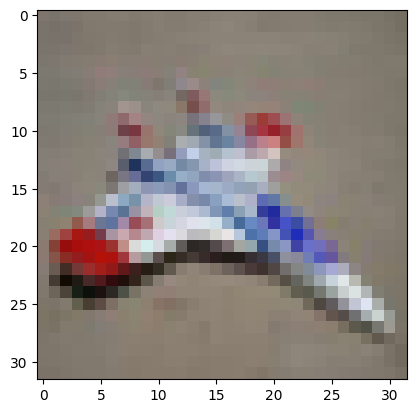

In [14]:
show_sample(*train_data[30])

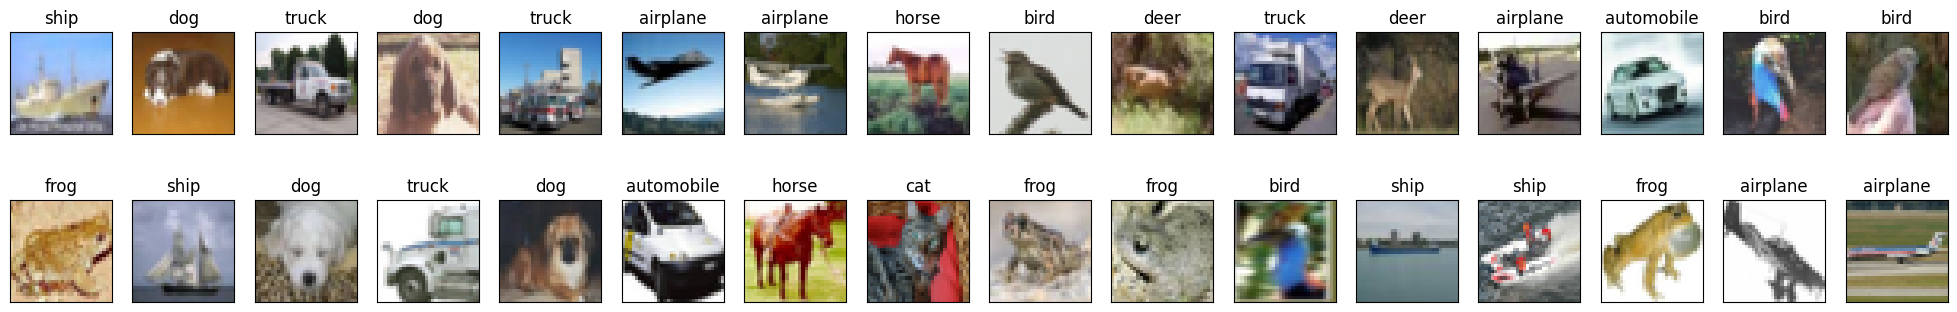

In [15]:
# plot the images in one batch, along with the corresponding labels
def show_batch(loader):
    # one batch of training images
    dataiter = iter(loader)
    images, labels = next(dataiter)
    images = images.numpy() # convert images to numpy for display

    fig = plt.figure(figsize=(25, 4))
    for idx in np.arange(batch_size):
        ax = fig.add_subplot(2, int(batch_size/2), idx+1, xticks=[], yticks=[])
        imshow(images[idx])
        ax.set_title(classes[labels[idx]])

show_batch(train_loader)

#Train own CNN

In [16]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [17]:
# Print a summary using torchinfo
def print_model_summary(model):
    return summary(model=model,
            input_size=(batch_size, 3, 32, 32), # make sure this is "input_size", not "input_shape"
            col_names=["input_size", "output_size", "num_params", "trainable"],
            col_width=20,
            row_settings=["var_names"]
    )

In [18]:
# Check if your system has cuda gpu or only cpu and get the currently available one
def get_available_device():
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Function to transfer from CPU to GPU
def move_to_device(tensor, device):
    # Move all individual tensors to chosen device, e.g. from cpu to gpu
    if isinstance(tensor, (list,tuple)):
        return [move_to_device(element, device) for element in tensor]
    return tensor.to(device, non_blocking=True)

# Execute transfer from CPU to GPU for each device
class DeviceDataLoader():
    # Wrap a dataloader to move data to a device
    def __init__(self, dataloader, device):
        self.dl = dataloader
        self.device = device

    def __iter__(self):
       # Transfer each batch to chosen device and return
        for i in self.dl:
            yield move_to_device(i, self.device)

    def __len__(self):
        # Return the number of batches
        return len(self.dl)


device = get_available_device()

# Move all the tensors to GPU
train_dl = DeviceDataLoader(train_loader, device)
valid_dl = DeviceDataLoader(valid_loader, device)
test_dl = DeviceDataLoader(test_loader, device)

## Train CNN from scratch without pre-trained models

In [ ]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # convolutional layer (sees 32x32x3 image tensor)
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        # convolutional layer (sees 16x16x16 tensor)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # convolutional layer (sees 8x8x32 tensor)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # linear layer (64 * 4 * 4 -> 500)
        self.fc1 = nn.Linear(64 * 4 * 4, 500)
        # linear layer (500 -> 10)
        self.fc2 = nn.Linear(500, 10)
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        # flatten image input
        x = x.view(-1, 64 * 4 * 4)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = self.fc2(x)
        return x

# create a complete CNN
model = ConvNet()
print(model)


## Train CNN based on pre-trained models

### Simple train and evaluate steps

In [19]:
num_classes = 10

# Hyperparameters
num_epochs = 20
lr = 0.001

In [27]:
def compute_accuracy(predicted, labels):
    predictions, predicted_labels = torch.max(predicted,dim=1)
    return torch.tensor(torch.sum(predicted_labels==labels).item()/len(predicted))

# For validation
def validate(model, dl, loss_func):
    model.eval()
    loss_per_batch, accuracy_per_batch=[], []
    for images, labels in dl:
        #start loop
        with torch.no_grad():
            predicted = model(images)
        loss_per_batch.append(loss_func(predicted,labels))
        accuracy_per_batch.append(compute_accuracy(predicted,labels))
    epoch_val_loss = torch.stack(loss_per_batch).mean().item()
    epoch_val_accuracy = torch.stack(accuracy_per_batch).mean().item()
    return epoch_val_loss, epoch_val_accuracy

# For evaluation/testing
def evaluate(model, dl, loss_func):
    model.eval()
    loss_per_batch, accuracy_per_batch=[], []

    class_correct = list(0. for _ in range(len(classes)))
    class_total = list(0. for _ in range(len(classes)))

    for images, labels in dl:
        #start loop
        with torch.no_grad():
            predicted = model(images)
        loss_per_batch.append(loss_func(predicted,labels))
        accuracy_per_batch.append(compute_accuracy(predicted,labels))

        # Calculate class-wise accuracy
        _, pred = torch.max(predicted, 1)
        correct_tensor = pred.eq(labels.data.view_as(pred))
        correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())

        for i in range(len(classes)):
            class_label = classes[i]
            class_correct[i] += np.sum(correct[labels.data.cpu().numpy() == i]) #np.sum(correct[labels.data == i]) if not torch.cuda.is_available() else
            class_total[i] += np.sum(labels.data.cpu().numpy() == i) #np.sum(labels.data == i)

    test_loss = torch.stack(loss_per_batch).mean().item()
    #test_accuracy = torch.stack(accuracy_per_batch).mean().item()
    test_accuracy = 100. * np.sum(class_correct) / np.sum(class_total)

    print(f'Test Loss: {test_loss:.6f}, Test Accuracy (Overall): {test_accuracy:.2f}% ({np.sum(class_correct)}/{np.sum(class_total)})') #{test_accuracy * 100:.2f}%

    for i in range(len(classes)):
        if class_total[i] > 0:
            print(f'Test Accuracy of {classes[i]}: {100 * class_correct[i] / class_total[i]:.2f}% '
                  f'({np.sum(class_correct[i])}/{np.sum(class_total[i])})')
        else:
            print(f'Test Accuracy of {classes[i]}: N/A (no training examples)')

    return test_loss, test_accuracy

# For training
def train(model, train_dl, valid_dl, epochs, max_lr, loss_func, optimizer): # LATER: add parameter lr_scheduler
    # seed needed due to batch shuffling?
    seed_all(42)

    results = []
    epoch_val_loss_min = np.Inf

    for epoch in range(epochs):
        model.train()
        train_losses=[]
        train_accuracy_per_batch=[]
        lrs = []

        for batch_idx, (images, labels) in enumerate(train_dl):
            predicted = model(images)
            loss = loss_func(predicted,labels)
            train_losses.append(loss)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # keep track of learning rate
            lrs.append(optimizer.param_groups[0]['lr'])
            train_accuracy_per_batch.append(compute_accuracy(predicted,labels))

            # logging
            if not batch_idx % 120:
                print (f'Epoch: {epoch+1:03d}/{epochs:03d} | '
                      f'Batch {batch_idx:03d}/{len(train_dl):03d} |'
                      f'Loss: {loss:.4f}')

        # LATER:
        #lr_scheduler.step()

        # no need to build the computation graph for backprop when computing accuracy
        with torch.set_grad_enabled(False):
            epoch_train_acc = torch.stack(train_accuracy_per_batch).mean().item()
            epoch_train_loss = torch.stack(train_losses).mean().item()
            epoch_val_loss, epoch_val_accuracy = validate(model, valid_dl, loss_func)

        results.append({'avg_valid_loss': epoch_val_loss,
                        'avg_val_acc': epoch_val_accuracy,
                        'avg_train_loss': epoch_train_loss,
                        'avg_train_acc': epoch_train_acc,
                        'lrs':lrs})

        # print training/validation statistics
        print(f'Epoch: {epoch+1:03d}/{epochs:03d}   Train Loss: {epoch_train_loss:.2f} | Train Acc.: {epoch_train_acc:.2f}%'
              f' | Validation Loss: {epoch_val_loss:.2f} | Validation Acc.: {epoch_val_accuracy:.2f}%')

        # save model if validation loss has decreased (validation loss ever increasing indicates possible overfitting.)
        if epoch_val_loss <= epoch_val_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            epoch_val_loss_min,
            epoch_val_loss))
            torch.save(model.state_dict(), 'model_cifar10.pt')
            epoch_val_loss_min = epoch_val_loss

    return results

### Train pre-trained ResNet50 from scratch (fine-tune)

In [ ]:
# Load pre-trained ResNet50 model
resnet50_no_pretrained_weights = torchvision.models.resnet50(weights=None) # initialize the weights randomly and train the entire network exclusively on the CIFAR dataset

# Modify the last fully connected layer for CIFAR-10
num_ftrs = resnet50_no_pretrained_weights.fc.in_features
resnet50_no_pretrained_weights.fc = nn.Linear(num_ftrs, num_classes)
resnet50_no_pretrained_weights.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
print_model_summary(resnet50_no_pretrained_weights)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 32, 32]      [32, 10]             --                   True
├─Conv2d (conv1)                         [32, 3, 32, 32]      [32, 64, 16, 16]     9,408                True
├─BatchNorm2d (bn1)                      [32, 64, 16, 16]     [32, 64, 16, 16]     128                  True
├─ReLU (relu)                            [32, 64, 16, 16]     [32, 64, 16, 16]     --                   --
├─MaxPool2d (maxpool)                    [32, 64, 16, 16]     [32, 64, 8, 8]       --                   --
├─Sequential (layer1)                    [32, 64, 8, 8]       [32, 256, 8, 8]      --                   True
│    └─Bottleneck (0)                    [32, 64, 8, 8]       [32, 256, 8, 8]      --                   True
│    │    └─Conv2d (conv1)               [32, 64, 8, 8]       [32, 64, 8, 8]       4,096                True
│    │    └─BatchN

In [ ]:
# Specify model
model = resnet50_no_pretrained_weights

# Instantiate the loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# Training the model
train(model, train_loader, loss_fn, optimizer, device, num_epochs)

# Evaluate the model
test_accuracy = evaluate(model, test_loader, device, num_epochs=num_epochs)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Epoch 1/20, Loss: 2.1135651489257814
Epoch 2/20, Loss: 1.9076840148925782
Epoch 3/20, Loss: 1.7208546852588653
Epoch 4/20, Loss: 1.8182479725837708
Epoch 5/20, Loss: 1.6056548762321472
Epoch 6/20, Loss: 1.5177997190475463
Epoch 7/20, Loss: 1.3385143717765808
Epoch 8/20, Loss: 1.2399633080005645
Epoch 9/20, Loss: 1.0848402963161468
Epoch 10/20, Loss: 1.0544283211946488
Epoch 11/20, Loss: 0.9583862205982209
Epoch 12/20, Loss: 0.8312428949832916
Epoch 13/20, Loss: 0.7783307733297348
Epoch 14/20, Loss: 0.6705117095470429
Epoch 15/20, Loss: 0.6157363369941712
Epoch 16/20, Loss: 0.6025980696439743
Epoch 17/20, Loss: 0.5433041753351688
Epoch 18/20, Loss: 0.4340498977482319
Epoch 19/20, Loss: 0.3958944693148136
Epoch 20/20, Loss: 0.3037646227568388
Test Accuracy: 73.61%


### Train pre-trained ResNet50 with pre-trained weights (fine-tune)

In [28]:
resnet50_fine_tuned_with_pretrained_weights = torchvision.models.resnet50(weights='ResNet50_Weights.DEFAULT') # Best available weights (currently alias for ResNet50_Weights.IMAGENET1K_V2)

# Modify the last fully connected layer for CIFAR-10
num_ftrs = resnet50_fine_tuned_with_pretrained_weights.fc.in_features
resnet50_fine_tuned_with_pretrained_weights.fc = nn.Linear(num_ftrs, num_classes)
resnet50_fine_tuned_with_pretrained_weights.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [29]:
%%time
# Specify model
model = resnet50_fine_tuned_with_pretrained_weights
model = move_to_device(model, device)

# Instantiate the loss function and optimizer
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
# LATER: Decay LR by a factor of 0.1 every 7 epochs
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Train the model
results = train(model, train_dl, valid_dl, num_epochs, lr, loss_func, optimizer) #LATER: add learning rate scheduler?

Epoch: 001/020 | Batch 000/1250 |Loss: 2.2839
Epoch: 001/020 | Batch 120/1250 |Loss: 1.3760
Epoch: 001/020 | Batch 240/1250 |Loss: 0.9384
Epoch: 001/020 | Batch 360/1250 |Loss: 1.4072
Epoch: 001/020 | Batch 480/1250 |Loss: 0.8710
Epoch: 001/020 | Batch 600/1250 |Loss: 0.8410
Epoch: 001/020 | Batch 720/1250 |Loss: 1.2193
Epoch: 001/020 | Batch 840/1250 |Loss: 0.6086
Epoch: 001/020 | Batch 960/1250 |Loss: 1.1363
Epoch: 001/020 | Batch 1080/1250 |Loss: 0.7587
Epoch: 001/020 | Batch 1200/1250 |Loss: 0.5426
Epoch: 001/020   Train Loss: 1.02 | Train Acc.: 0.67% | Validation Loss: 0.72 | Validation Acc.: 0.76%
Validation loss decreased (inf --> 0.723514).  Saving model ...
Epoch: 002/020 | Batch 000/1250 |Loss: 0.4651
Epoch: 002/020 | Batch 120/1250 |Loss: 0.7185
Epoch: 002/020 | Batch 240/1250 |Loss: 0.6588
Epoch: 002/020 | Batch 360/1250 |Loss: 0.4494
Epoch: 002/020 | Batch 480/1250 |Loss: 1.1292
Epoch: 002/020 | Batch 600/1250 |Loss: 0.6939
Epoch: 002/020 | Batch 720/1250 |Loss: 0.4288
Epo

In [30]:
%%time
# Evaluate the model
model.load_state_dict(torch.load('model_cifar10.pt'))

#test_accuracy = evaluate(model, test_loader, device)
with torch.set_grad_enabled(False): # save memory during inference
    #_, test_accuracy = evaluate(model, test_dl, loss_func)
    #print(f"Test Accuracy (Overall): {test_accuracy * 100:.2f}%")
    evaluate(model, test_dl, loss_func)

Test Loss: 0.517576, Test Accuracy (Overall): 84.22% (8422.0/10000.0)
Test Accuracy of airplane: 88.10% (881.0/1000.0)
Test Accuracy of automobile: 92.50% (925.0/1000.0)
Test Accuracy of bird: 77.90% (779.0/1000.0)
Test Accuracy of cat: 71.40% (714.0/1000.0)
Test Accuracy of deer: 87.00% (870.0/1000.0)
Test Accuracy of dog: 72.20% (722.0/1000.0)
Test Accuracy of frog: 90.00% (900.0/1000.0)
Test Accuracy of horse: 83.80% (838.0/1000.0)
Test Accuracy of ship: 90.90% (909.0/1000.0)
Test Accuracy of truck: 88.40% (884.0/1000.0)
CPU times: user 6.99 s, sys: 42.9 ms, total: 7.03 s
Wall time: 7.15 s


In [31]:
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

Model's state_dict:
conv1.weight 	 torch.Size([64, 3, 7, 7])
bn1.weight 	 torch.Size([64])
bn1.bias 	 torch.Size([64])
bn1.running_mean 	 torch.Size([64])
bn1.running_var 	 torch.Size([64])
bn1.num_batches_tracked 	 torch.Size([])
layer1.0.conv1.weight 	 torch.Size([64, 64, 1, 1])
layer1.0.bn1.weight 	 torch.Size([64])
layer1.0.bn1.bias 	 torch.Size([64])
layer1.0.bn1.running_mean 	 torch.Size([64])
layer1.0.bn1.running_var 	 torch.Size([64])
layer1.0.bn1.num_batches_tracked 	 torch.Size([])
layer1.0.conv2.weight 	 torch.Size([64, 64, 3, 3])
layer1.0.bn2.weight 	 torch.Size([64])
layer1.0.bn2.bias 	 torch.Size([64])
layer1.0.bn2.running_mean 	 torch.Size([64])
layer1.0.bn2.running_var 	 torch.Size([64])
layer1.0.bn2.num_batches_tracked 	 torch.Size([])
layer1.0.conv3.weight 	 torch.Size([256, 64, 1, 1])
layer1.0.bn3.weight 	 torch.Size([256])
layer1.0.bn3.bias 	 torch.Size([256])
layer1.0.bn3.running_mean 	 torch.Size([256])
layer1.0.bn3.running_var 	 torch.Size([256])
layer1.0.bn3.num

In [32]:
# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Streaming output truncated to the last 5000 lines.

        [[[3.8848e-13, 1.3844e-10, 1.1574e-12],
          [1.3459e-10, 1.6948e-10, 2.8625e-10],
          [2.1317e-12, 4.2116e-10, 3.4962e-09]],

         [[9.3055e-10, 1.1440e-09, 3.2718e-11],
          [3.7418e-11, 7.4922e-10, 1.1694e-09],
          [4.8681e-13, 2.1174e-10, 3.4581e-09]],

         [[2.2151e-13, 3.0723e-10, 1.2104e-11],
          [1.3506e-10, 1.7889e-10, 3.9672e-10],
          [7.5118e-12, 6.3905e-10, 2.1795e-09]],

         ...,

         [[1.9225e-10, 1.4055e-10, 5.5180e-17],
          [8.7934e-11, 3.9531e-09, 1.1259e-13],
          [2.9846e-17, 8.1061e-14, 1.4613e-13]],

         [[1.6122e-12, 6.1757e-10, 1.1549e-11],
          [4.0852e-11, 6.3665e-10, 6.8257e-10],
          [1.4111e-12, 5.0495e-10, 4.7273e-09]],

         [[5.1320e-19, 8.5435e-12, 1.7386e-15],
          [1.0902e-15, 1.3053e-09, 4.5608e-12],
          [1.3771e-15, 1.3124e-11, 3.7444e-10]]],


        ...,


        [[[8.7730e-18, 7.4838e-15, 4.558

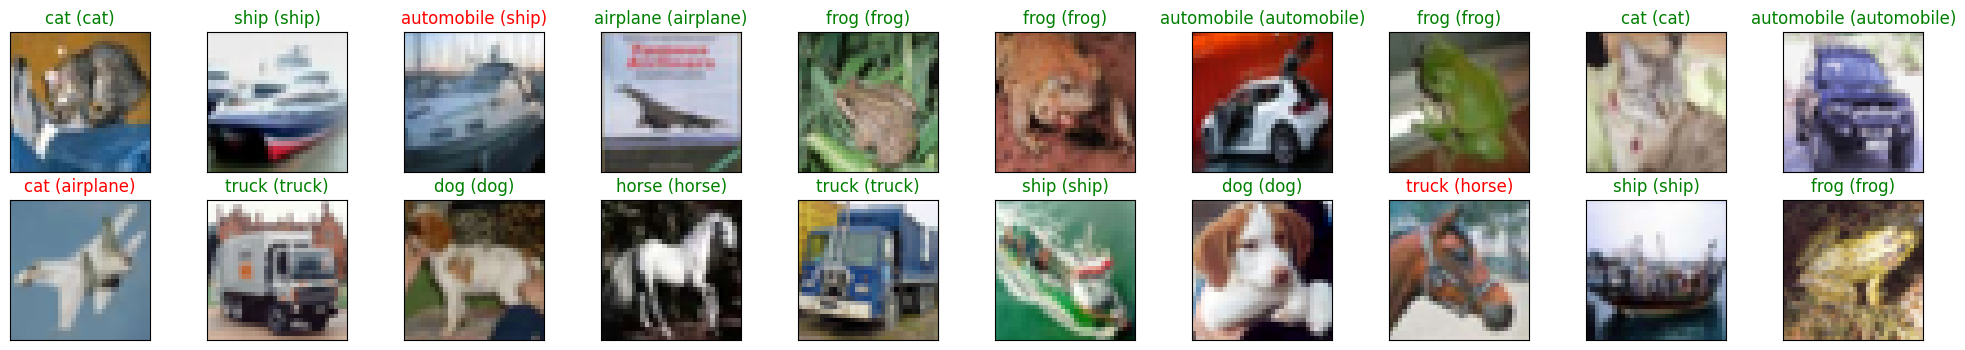

In [33]:
# Visualize sample test results
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)
images.numpy()

# move model inputs to the specified device
images = move_to_device(images, device)
images_cpu = images.cpu().numpy()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(preds_tensor.cpu().numpy())

# plot 20 images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    imshow(images_cpu[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))

### Train pre-trained ResNet50 with pre-trained weights (train classification layer only)

In [ ]:
resnet50_classification_layer_only = torchvision.models.resnet50(weights='ResNet50_Weights.DEFAULT')
for param in resnet50_classification_layer_only.parameters():
  param.requires_grad = False

# Modify the last fully connected layer for CIFAR-10
num_ftrs = resnet50_classification_layer_only.fc.in_features
resnet50_classification_layer_only.fc = nn.Linear(num_ftrs, num_classes)
resnet50_classification_layer_only.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
# Specify model
model = resnet50_classification_layer_only

# Instantiate the loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
# Note: Only parameters of final layer are being optimized as opposed to before.
optimizer = optim.Adam(model.fc.parameters(), lr=lr) # LATER: add e.g. momentum=0.9?
# LATER: Decay LR by a factor of 0.1 every 7 epochs
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Training the model
train(model, train_loader, loss_fn, optimizer, device, num_epochs) #LATER: add learning rate scheduler?

# Evaluate the model
test_accuracy = evaluate(model, test_loader, device)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Epoch 1/20, Loss: 1.8551620482444764
Epoch 2/20, Loss: 1.737576229572296
Epoch 3/20, Loss: 1.7235014068603516
Epoch 4/20, Loss: 1.726559974861145
Epoch 5/20, Loss: 1.7300274063110352
Epoch 6/20, Loss: 1.7214349800109863
Epoch 7/20, Loss: 1.7245086373329161
Epoch 8/20, Loss: 1.7324916029930115
Epoch 9/20, Loss: 1.7256877207756043
Epoch 10/20, Loss: 1.7262854884147645
Epoch 11/20, Loss: 1.7337947087287904
Epoch 12/20, Loss: 1.7291060347557068
Epoch 13/20, Loss: 1.7275852579116822
Epoch 14/20, Loss: 1.734032555770874
Epoch 15/20, Loss: 1.7315834421157836
Epoch 16/20, Loss: 1.7281323501586914
Epoch 17/20, Loss: 1.7294791563034058
Epoch 18/20, Loss: 1.7375080949783326
Epoch 19/20, Loss: 1.730202120399475
Epoch 20/20, Loss: 1.7342988404273987
Test Accuracy: 45.66%


# Plot training/test results

In [34]:
# Results of model 1

# Training Loss
avg_training_loss=[]
for result in results:
    avg_training_loss.append(result['avg_train_loss'])

# Training Accuracy
avg_training_accuracy=[]
for result in results:
    avg_training_accuracy.append(result['avg_train_acc'])


# Validation Loss
avg_validation_loss=[]
for result in results:
    avg_validation_loss.append(result['avg_valid_loss'])

# Validation Accuracy
avg_validation_accuracy=[]
for result in results:
    avg_validation_accuracy.append(result['avg_val_acc'])



# Epochs count
epoch_count=[]
for i in range(num_epochs):
    epoch_count.append(i)

## Training vs. Validation Loss of a model

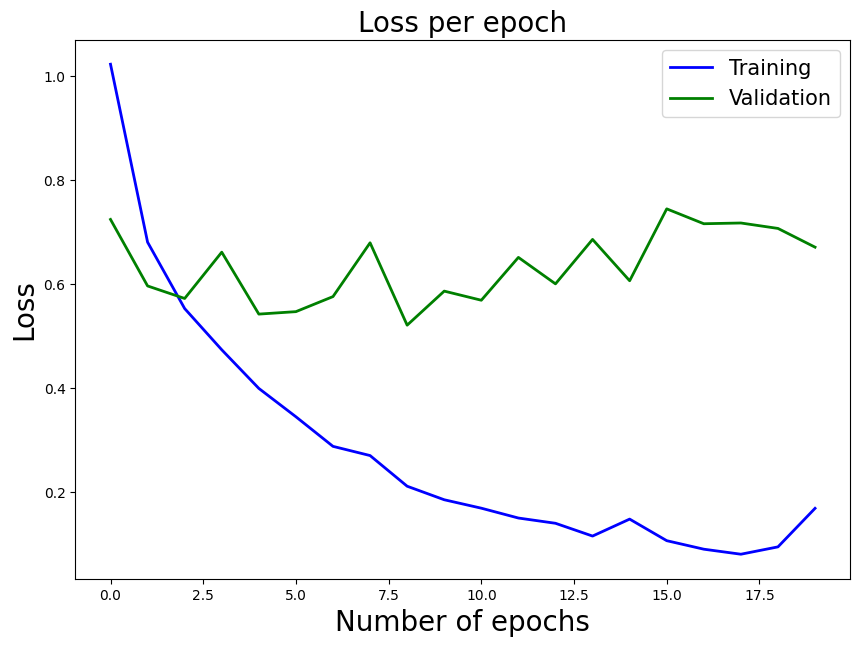

In [35]:
figure(figsize=(10,7))
plt.plot(epoch_count, avg_training_loss, 'b-',label="Training", linewidth='2')
plt.plot(epoch_count, avg_validation_loss, 'g-', label="Validation", linewidth='2')
plt.title("Loss per epoch", fontsize=20)
plt.xlabel("Number of epochs", fontsize=20)
plt.ylabel("Loss", fontsize=20)
plt.legend(fontsize=15)
plt.show()

## Training vs. Validation Accuracy of a model

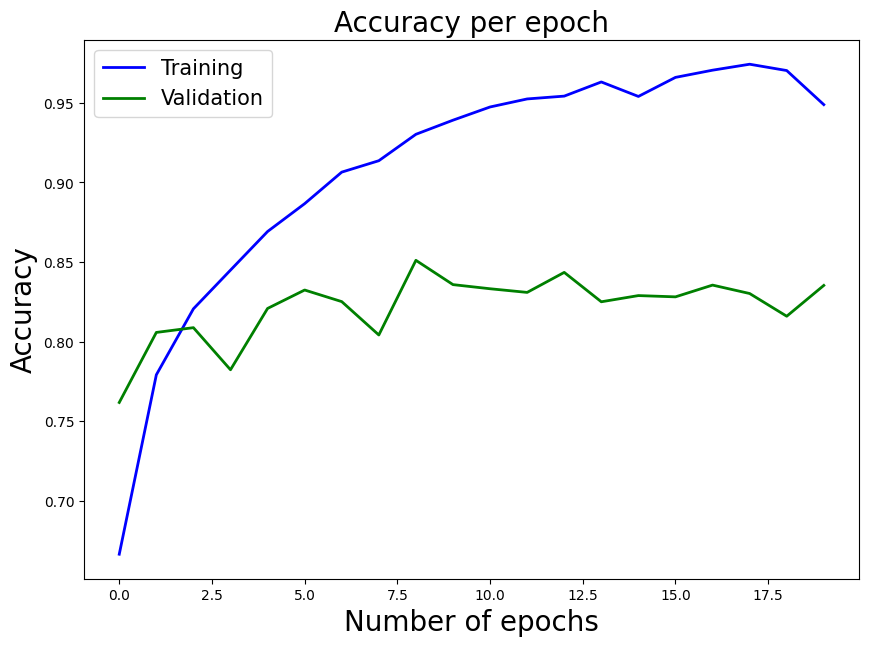

In [36]:
figure(figsize=(10,7))
plt.plot(epoch_count, avg_training_accuracy, 'b-', label="Training", linewidth='2')
plt.plot(epoch_count, avg_validation_accuracy, 'g-', label="Validation", linewidth='2')
plt.title("Accuracy per epoch", fontsize=20)
plt.xlabel("Number of epochs", fontsize=20)
plt.ylabel("Accuracy",fontsize=20)
plt.legend(fontsize=15)
plt.show()